# Multiple Linear Regression

We will be using a small dataset containing the data for the Boston housing market and will try to predict the value of houses (represented by the MEDV value) using only the percentage of people of lower status in the area (represented by the LSTAT variable).

In [1]:
# import all the required libraries and put matplotlib in inline mode to plot on the notebook
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We define a utility function to compute the value of the polynomial given x

In [2]:
def compute_polynomial_model(x, coef, intercept):
    """Compute the polynomial given the input x, the intercept and the coefficients"""
    min_x = min(x)
    max_x = max(x)
    xp = np.arange(min_x, max_x, (max_x-min_x)/100.0)

    x = xp
    yp = intercept

    for w in coef:
        yp = yp + w * x
        x = x * xp
    return xp,yp

Function to generate the variable names used for a polynomial approximation. For example, given the variable LSTAT and a degree of three it generates the list ['LSTAT', 'LSTAT2', 'LSTAT3']

In [3]:
def generate_variables(original_column, degree):
    """Generates the list of variables for a polynomial approximator"""
    v = [original_column]
    for d in range(2,degree+1):
        v.append(original_column+str(d))
    return v

Given a dataset, the name of a column and a degree it generates all the additional columns needed to perform a polynomial regression

In [4]:
def add_degrees(dataset,original_column, degree):
    """Given a column name and the degree of a polynomial, it adds 
    all the extra columns needed for a polynomial approximator"""
    
    new_dataset = dataset
    current_column = original_column
    for d in range(2,degree+1):
        column_name = original_column+str(d)

        new_dataset[column_name] = new_dataset[current_column]*dataset[original_column]

        current_column = column_name

    return new_dataset


Plot the set of original data against the data generated by the model

In [5]:
def plot_approximator(x,y,xp,yp,title=""):
    """Plots the original data (x,y) and a set of point (xp,yp) showing the model approximation"""


    plt.scatter(x, y,  color='blue')
    plt.plot(xp, yp, color='red', linewidth=3)
    plt.xlabel("LSTAT")
    plt.ylabel("MEDV")
    
    if (title!=""):
        plt.title(title)

    plt.xlim([0,40])
    plt.ylim([0,60])
    plt.show()

Read the boston housing dataset and check the variables

In [6]:
df = pd.read_csv('housing.csv')
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# Simple linear regression
It fits the data using the model $y = w_0 + w_1x$ using the variable LSTAT (percentage of lower status of the population) as input and MEDV (median value of owner occupied homes in $1000s) as target. 

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


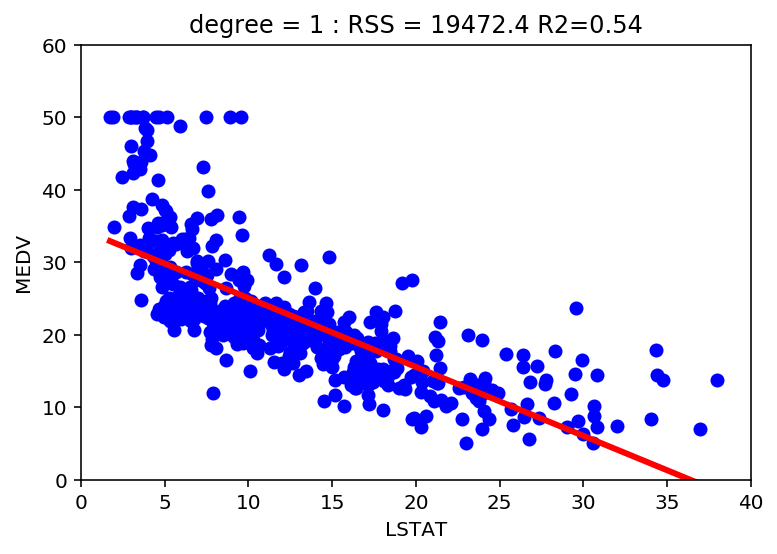

In [7]:
# compute the data inputs
dataset_train_x = df[generate_variables('LSTAT',1)].values
x = dataset_train_x.reshape(506, 1)

# compute the data output
dataset_train_y = df.MEDV.values
y = dataset_train_y.reshape(506, 1)

# apply simple linear regression to fit the data
regr = linear_model.LinearRegression()
regr.fit(x, y)

# model output for the input data
yp = regr.predict(x)

# compute the model output as a line
xm,ym = compute_polynomial_model(x[:,0],regr.coef_, regr.intercept_)

# compute rss cost
rss = sum((yp-y)*(yp-y))

# the cost as R^2
r2 = regr.score(x,y)

title = "degree = 1 : RSS = "+str(round(rss[0],1)) + " R2="+str(round(r2,2))

# plot the result
plot_approximator(x[:,0],y,xm,ym,title)


Function to compute the polynomial regression for one input variable, one output variable and a degree

In [8]:
def compute_polynomial_regression(dataset, variable, target, degree):

    extended_dataset = add_degrees(dataset, variable, degree)

    dataset_train_x = extended_dataset[generate_variables(variable,degree)].values
    dataset_train_y = extended_dataset[target].values

    x = dataset_train_x.reshape(len(dataset), degree)
    y = dataset_train_y.reshape(len(dataset), 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    yp = regr.predict(x)

    rss = sum((yp-y)*(yp-y))
    r2 = regr.score(x,y)



    # the abscissa
    xm,ym = compute_polynomial_model(x[:,0],regr.coef_[0], regr.intercept_)

    return xm, ym, yp, rss[0], r2

Compute an approximation using a second degree polynomial

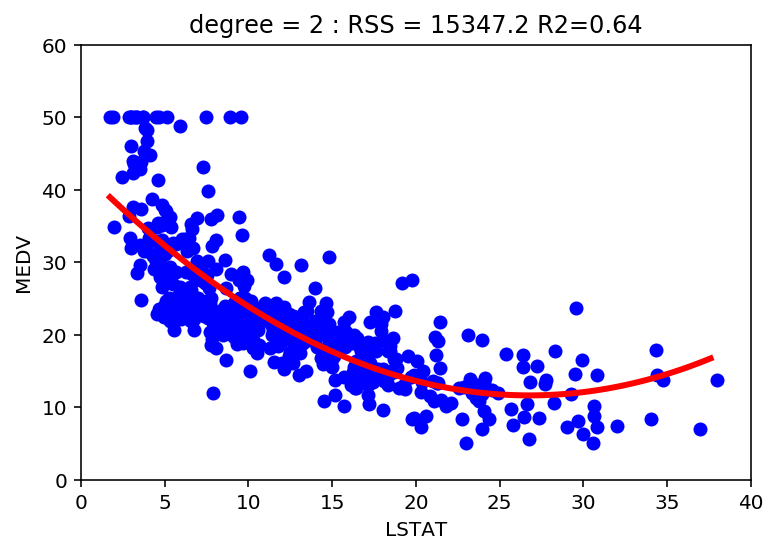

In [9]:
xm,ym,yp,rss,r2 = compute_polynomial_regression(df,'LSTAT', 'MEDV', 2)
title = "degree = 2 : RSS = "+str(round(rss,1)) + " R2="+str(round(r2,2))
plot_approximator(x[:,0],y,xm,ym,title)

Approximate using a third degree polynomial

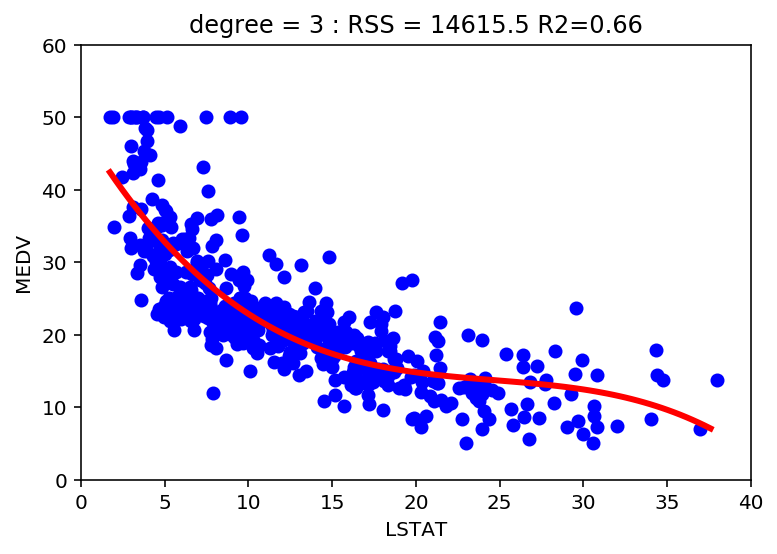

In [10]:
xm,ym,yp,rss,r2 = compute_polynomial_regression(df,'LSTAT', 'MEDV', 3)
title = "degree = 3 : RSS = "+str(round(rss,1)) + " R2="+str(round(r2,2))
plot_approximator(x[:,0],y,xm,ym,title)

Approximate using a fourth degree polynomial

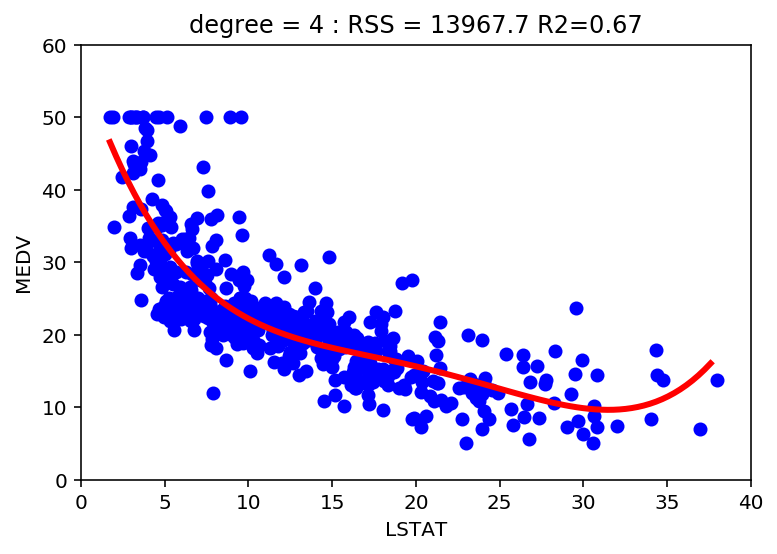

In [11]:
xm,ym,yp,rss,r2 = compute_polynomial_regression(df,'LSTAT', 'MEDV', 4)
title = "degree = 4 : RSS = "+str(round(rss,1)) + " R2="+str(round(r2,2))
plot_approximator(x[:,0],y,xm,ym,title)

Approximate using a fifth degree polynomial

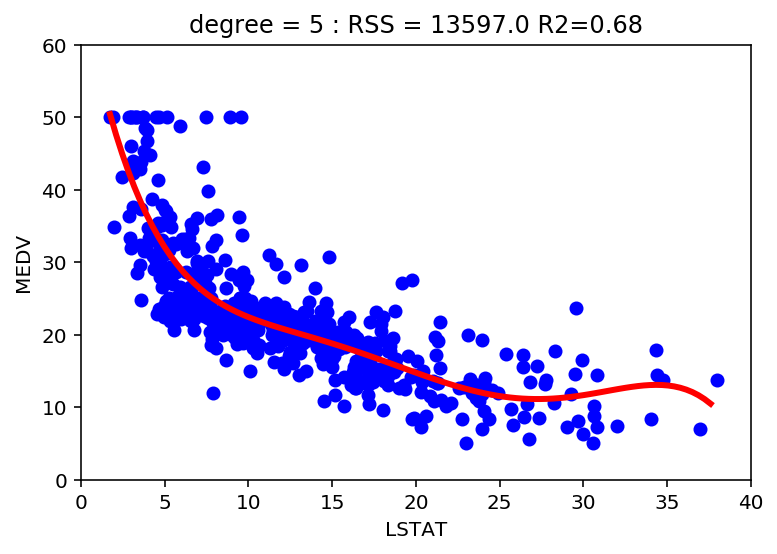

In [12]:
xm,ym,yp,rss,r2 = compute_polynomial_regression(df,'LSTAT', 'MEDV', 5)
title = "degree = 5 : RSS = "+str(round(rss,1)) + " R2="+str(round(r2,2))
plot_approximator(x[:,0],y,xm,ym,title)

Let's be extreme and try a polynom of degree 10

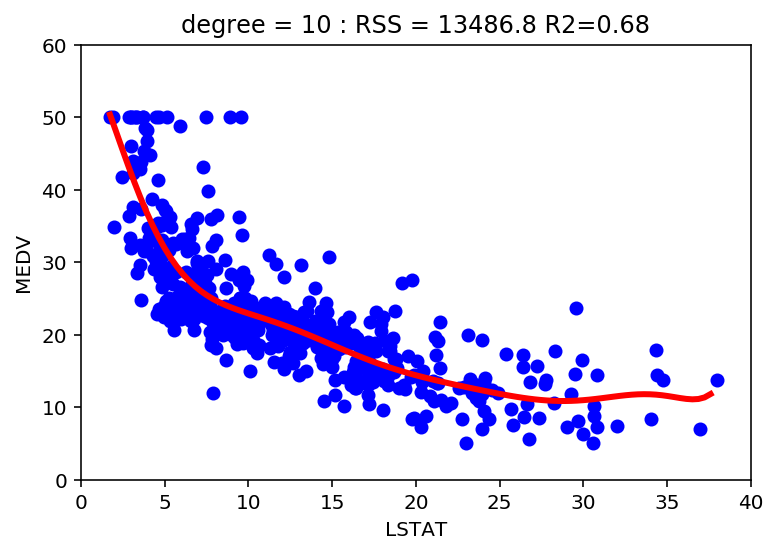

In [13]:
xm,ym,yp,rss,r2 = compute_polynomial_regression(df,'LSTAT', 'MEDV', 10)
title = "degree = 10 : RSS = "+str(round(rss,1)) + " R2="+str(round(r2,2))
plot_approximator(x[:,0],y,xm,ym,title)

## Model Evaluation Using a Test Set
To evaluate the model we now split the data between train and test using 2/3 of the data for training and 1/3 for testing. Then, we compute the model using the training data and evaluate it using the test data.

In [14]:
from sklearn import model_selection

def compute_polynomial_regression_holdout(dataset, variable, target, degree, test_size=0.33, random_state=1234):
    '''Computes RSS and R2 statistics over the train and test set.

    test_size is the percentage of data used for testing (default is 1/3)
    random_state is the seed used for sampling the data and it is used for replicability

    '''
    
    ### Add higher degree of the target variable
    extended_dataset = add_degrees(dataset, variable, degree)

    ### Split train and test
    train_data, test_data = model_selection.train_test_split(extended_dataset, test_size=0.33, random_state=1234)

    ### select only the values that we will be use
    train_x = train_data[generate_variables(variable,degree)].values
    train_y = train_data[target].values

    test_x = test_data[generate_variables(variable,degree)].values
    test_y = test_data[target].values

    ### reshape training and testing data to fit sklearn required format
    train_x = train_x.reshape(len(train_x), degree)
    train_y = train_y.reshape(len(train_y), 1)
    test_x = test_x.reshape(len(test_y), degree)
    test_y = test_y.reshape(len(test_y), 1)

    tss_test = sum((test_y - (sum(test_y)/float(len(test_y))))**2)[0]

    regr = linear_model.LinearRegression()

    regr.fit(train_x, train_y)

    y_predicted_from_test = regr.predict(test_x)
    rss_test = sum( (test_y-y_predicted_from_test)*(test_y-y_predicted_from_test) )[0]

    return rss_test, (1-rss_test/tss_test)

We can now compute RSS and R2 statistics over the test set for different degrees and plot the result.

In [15]:
max_polynomial = 15
rss = np.zeros(max_polynomial)
r2 = np.zeros(max_polynomial)

for i in range(max_polynomial):
    rss[i], r2[i] = compute_polynomial_regression_holdout(df,'LSTAT','MEDV',i+1)

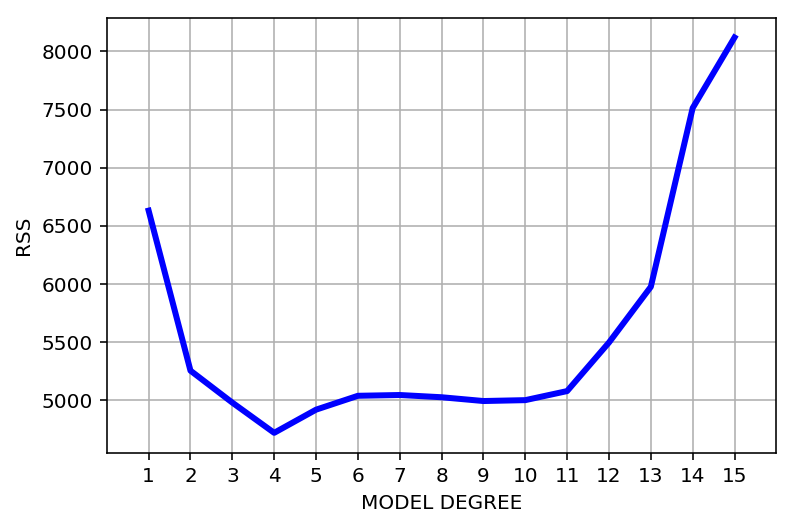

In [16]:
plt.xlabel("MODEL DEGREE")
plt.ylabel("RSS")

plt.xlim([0,16])
plt.xticks(range(1,16))
plt.grid()
plt.plot(range(1,max_polynomial+1), rss, color="blue",linewidth=3);

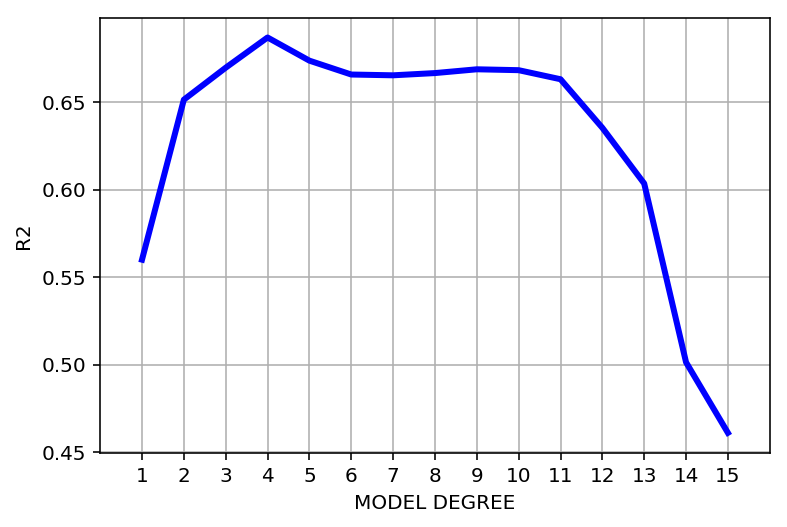

In [17]:
plt.xlabel("MODEL DEGREE")
plt.ylabel("R2")

plt.xlim([0,16])
plt.xticks(range(1,16))
plt.grid()
plt.plot(range(1,max_polynomial+1), r2, color="blue",linewidth=3);